In [1]:
# ruff: noqa: E402 F401
"""
https://www.kaggle.com/c/dogs-vs-cats/overview
"""
import os
from pathlib import Path

iskaggle = os.getenv("KAGGLE_KERNEL_RUN_TYPE")

# If on kaggle, install packages
if iskaggle:
    os.system("pip install fastai")

import pandas as pd
from fastai.callback.schedule import fine_tune
from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import ColReader, ColSplitter
from fastai.metrics import accuracy
from fastai.text.data import TextBlock
from fastai.text.learner import AWD_LSTM, text_classifier_learner

# TODO Save model
# model_file = Path("model.pkl")

!wget -c "https://raw.githubusercontent.com/BurnySc2/deep-learning-examples/82179fab48595b0730ca00502fde0eecef92a7d3/text_sentiment_classification/CMU-MOSEI.csv" -O CMU-MOSEI.csv

  Obtaining dependency information for loguru from https://files.pythonhosted.org/packages/03/0a/4f6fed21aa246c6b49b561ca55facacc2a44b87d65b8b92362a8e99ba202/loguru-0.7.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


--2024-01-16 06:35:01--  https://raw.githubusercontent.com/BurnySc2/deep-learning-examples/82179fab48595b0730ca00502fde0eecef92a7d3/text_sentiment_classification/CMU-MOSEI.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3512157 (3.3M) [text/plain]
Saving to: 'CMU-MOSEI.csv'

CMU-MOSEI.csv       100%[===================>]   3.35M  --.-KB/s    in 0.05s   

2024-01-16 06:35:01 (66.1 MB/s) - 'CMU-MOSEI.csv' saved [3512157/3512157]



In [2]:
# load csv file with text and labels
def get_train_valid_items(my_path: Path) -> pd.DataFrame:
    for file in sorted(my_path.iterdir()):
        if file.suffix != ".csv":
            continue
        # Only read one file for now
        df = pd.read_csv(file)
        # Turn text to lowercase
        df["text"] = df["text"].apply(lambda text: text.lower())
        # Create one new columns
        df["is_valid"] = df["mode"].apply(lambda mode: mode == "valid")
        return df

# TODO Why does this not work
def get_x(item: pd.DataFrame) -> str:
    return item["text"]

def get_y(item: pd.DataFrame) -> str:
    return item["label"]

# TODO use https://docs.fast.ai/text.data.html#textblock.from_df in different file
# TODO use https://docs.fast.ai/text.data.html#textdataloaders.from_df in different file
# TODO use https://docs.fast.ai/text.data.html#textdataloaders.from_csv in different file
# TODO with tabular learner?

# Create a DataBlock for text data
dblock = DataBlock(
    blocks=(
        # Input is a pandas dataframe
        # TODO Use custom text encodes/transformer
        TextBlock.from_df(
            text_cols="text",
            seq_len=72,
        ),
        # Output block has a numeric value
        RegressionBlock(),
    ),
    get_items=get_train_valid_items,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    # get_x=get_x,
    # get_y=get_y,
    splitter=ColSplitter(col="is_valid"),
)

# Create dataloader
dls = dblock.dataloaders(source=Path("."))

In [3]:
# Show preview
dls.show_batch(max_n=3)

,text,text_
0,xxbos i went over the four main product types along with her down payments and seller 's concession in this video we 're going to take a look into the conventional loan for a single - family home so if you see here we have a minimum down payment of three percent now that is if you are a first time xxunk or have not had a property interest in a home in the past three years you can qualify for that three percent otherwise you 're looking at a five percent down payment at minimum and then we have a three percent seller 's concession now that 's if you 're putting anywhere from three percent to ten percent down if you put ten percent to twenty percent down the seller 's concession goes up to six percent and any more than twenty percent it goes all the way,0.3333333432674408
1,xxbos good afternoon welcome to the xxunk update i 'm trying to keep things pretty brief today as everyone is very busy i 'd like to start by welcoming xxunk xxunk into the team she joins us from xxunk and will work now as a xxunk a long side peter and katie so welcome along xxunk and good luck to emma in her new role at xxunk february it was busy for february we think will be a little bit xxunk a little bit easier to get through some work but compared to february last year if you felt busy it was because you were particularly if you were in doc prep and it was up by 21 % in terms of volume on february last year here which is huge xxunk also had an xxunk of about seven percent year - on - year compared to the month on,1.0
2,xxbos hey guys its crystal i help people get free devices for their hearing loss and this video is specifically for xxunk and veteran service officers so if you know anybody who could benefit please share this information with them it 's very helpful if they have hearing loss i know a lot of xxunk get their hearing aids through the va this is another program you can use and you can go to the va and get this device at no cost so what this is i 'll tell you about the what the actual devices and then how you can take it to either your xxunk or your va and get the phone so it 's a phone that 's xxunk and it writes out word - for - word what 's being said so some folks use it heavily they use the captions heavily they hardly even,1.0


SuggestedLRs(valley=0.002511886414140463)

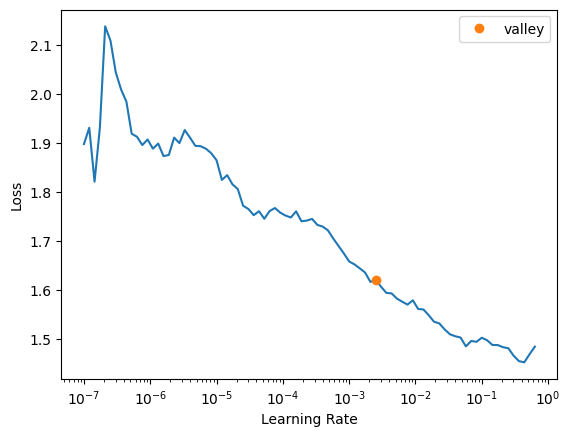

In [4]:
# Create a text learner
# TODO Other metrics like error rate
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

# Find a good learning rate
learn.lr_find()

In [5]:
epochs = 4
# Choose a learning rate based on the plot
lr = 1e-2

# Fine-tune the model
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.071150,0.826103,0.231427,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.835986,0.680729,0.231427,00:21
1,0.695571,0.600551,0.231427,00:21
2,0.604735,0.568428,0.231427,00:21
3,0.542923,0.570432,0.231427,00:20


In [6]:
# Predict
learn.predict("I really liked that movie!")

((2.241971969604492,), tensor([2.2420]), tensor([2.2420]))

In [7]:
learn.predict("I hated that movie!")

((-1.8413300514221191,), tensor([-1.8413]), tensor([-1.8413]))

In [8]:
learn.predict("That movie was disgusting!")

((-2.2331418991088867,), tensor([-2.2331]), tensor([-2.2331]))